In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import logging
import warnings
from random import shuffle
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import umap

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

In [3]:
logging.basicConfig(
        filename='doc2vec.log',
        level=logging.DEBUG,
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%H:%M:%S')

## Load Data

In [4]:
df = pd.read_csv('yelp_sample.csv')
df = df[df.stars.isin([1, 3, 5])]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698585 entries, 0 to 999999
Data columns (total 2 columns):
stars    698585 non-null int64
text     698585 non-null object
dtypes: int64(1), object(1)
memory usage: 16.0+ MB


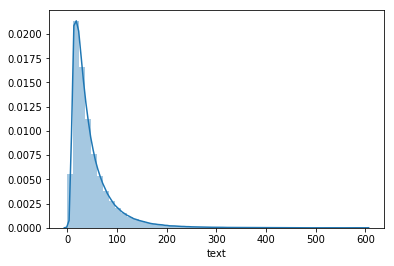

In [19]:
sns.distplot(df.text.str.split().str.len());

## Doc2Vec

In [6]:
sentences = []
for i, (stars, text) in df.iterrows():
    sentences.append(TaggedDocument(words=text.split(), tags=[i]))

In [8]:
size=100
window=5
min_count=100
epochs=5,
negative=5
dm_concat=0
dbow_words=0

In [63]:
model = Doc2Vec(documents=sentences,
                dm=1,
                size=size,
                window=window,
                min_count=min_count,
                workers=8,
                epochs=epochs,
                negative=negative,
                dm_concat=dm_concat,
                dbow_words=dbow_words)
# model.build_vocab(sentences)

In [21]:
model.train(sentences, total_examples=model.corpus_count, epochs=model.epochs)

In [64]:
pd.DataFrame(model.most_similar('good'), columns=['token', 'similarity'])

,token,similarity
0,great,0.782345
1,decent,0.765435
2,awesome,0.664795
3,amazing,0.656353
4,bad,0.649510
5,alright,0.624562
6,excellent,0.608222
7,fantastic,0.606341
8,average,0.598292
9,okay,0.587097


## Persist Model

In [65]:
model.save('test.model')

In [9]:
model = Doc2Vec.load('test.model')

## Evaluate

In [9]:
y = pd.factorize(df.stars)[0]

In [ ]:
X = np.zeros(shape=(len(df), size))
for i in range(len(df)):
    X[i] = model.docvecs[i]

In [ ]:
embedding = pd.DataFrame(umap.UMAP().fit_transform(X),
                         columns=['x', 'y'])
embedding.to_csv('umap.csv', index=False)

In [11]:
embedding = pd.read_csv('umap.csv')

In [12]:
embedding['label'] = y

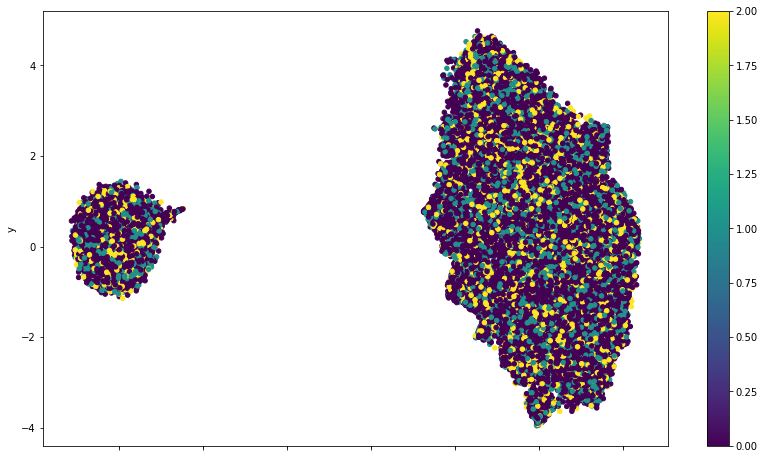

In [20]:
e = embedding.sample(frac=.1)
e.plot.scatter(x='x', y='y', c=e.label, figsize=(14, 8), cmap='viridis');

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [73]:
mode = pd.Series(y_train).mode().iloc[0]
baseline = accuracy_score(y_true=y_test, y_pred=np.full_like(y_test, fill_value=mode))
print(f'Baseline Score: {baseline:.2%}')

Baseline Score: 63.39%


In [75]:
pd.Series(y_test).value_counts(normalize=True)

0    0.633896
1    0.209008
2    0.157096
dtype: float64

In [76]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [77]:
class_weights

array([0.52585038, 1.59482003, 2.12184306])

## LightGBM

## Random Forest

In [78]:
rf = RandomForestClassifier(n_jobs=-1,  
                            n_estimators=100,
                            class_weight='balanced_subsample')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred):.2%}')

Accuracy: 63.39%


In [79]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[88566,     0,     0],
       [29202,     0,     0],
       [21949,     0,     0]])

## Logistic Regression

In [80]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f'Accuracy: {accuracy_score(y_true=y_test, y_pred=y_pred):.2%}')

Accuracy: 26.62%


In [81]:
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[17891, 22893, 47782],
       [ 5990,  7434, 15778],
       [ 4480,  5597, 11872]])